In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
import pingouin as pg
from mpl_toolkits import mplot3d
import random

In [13]:
dataset=pd.read_csv('Social_Network_Ads.csv')
dataset.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


### Checking Correlation 

In [14]:
x=dataset[['Age','EstimatedSalary']]
y=dataset[['Gender']]

In [63]:
pg.corr(x=x['Age'],y=x['EstimatedSalary'])

,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,400,0.155,"[0.06, 0.25]",0.024,0.019,0.001846,7.844,0.877


### Spliting Data 

In [15]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

In [16]:
frame_train=x_train.copy()
frame_test=x_test.copy()
frame_train['Gender']=y_train.values
frame_test['Gender']=y_test.values

### Normalizing The Estimate Column

In [17]:
def normalize(x,min_value,max_value):
    return (x-min_value)/(max_value-min_value)

In [18]:
values=[]
min_age_value=frame_train['EstimatedSalary'].values.min()
max_age_value=frame_train['EstimatedSalary'].values.max()
for i in frame_train['EstimatedSalary'].values:
    values.append(normalize(i,min_value=min_age_value,max_value=max_age_value))
arr_values=np.array(values)
arr_values=arr_values.reshape((320,1))
normalize_frame_train=frame_train.copy()
normalize_frame_train['EstimatedSalary']=arr_values

In [19]:
normalize_frame_train.head()

,Age,EstimatedSalary,Gender
336,58,0.955556,Male
64,59,0.503704,Female
55,24,0.296296,Female
106,26,0.148148,Female
300,58,0.170370,Female


### Grouping with Gender 

In [20]:
normalize_male=normalize_frame_train.groupby('Gender').get_group('Male')
normalize_female=normalize_frame_train.groupby('Gender').get_group('Female')

### Finding Covariance 

In [23]:
age_male=normalize_male['Age'].values
salary_male=normalize_male['EstimatedSalary'].values
male_cov=np.cov(age_male,salary_male)
age_male_mean=age_male.mean()
salary_male_mean=salary_female.mean()

In [22]:
age_female=normalize_female['Age'].values
salary_female=normalize_female['EstimatedSalary'].values
female_cov=np.cov(age_female,salary_female)
age_female_mean=age_female.mean()
salary_female_mean=salary_female.mean()

### Creating sigma inverse 

In [24]:
male_cov_determinant=np.linalg.det(male_cov)
male_sigma_inverse=(1/male_cov_determinant)*male_cov
male_sigma_inverse

array([[1.71911727e+01, 7.82120812e-02],
       [7.82120812e-02, 1.11972698e-02]])

In [25]:
female_cov_determinant=np.linalg.det(female_cov)
female_sigma_inverse=(1/female_cov_determinant)*female_cov
female_sigma_inverse

array([[1.43556384e+01, 4.83559529e-02],
       [4.83559529e-02, 8.56250869e-03]])

### Normal distribution

##### Creating (x-mean) vector

In [123]:
def multi_variant_normal_distribution(x,det_cov,inv_cov):
    res=list()
    for vec in x:
        y=(1/np.sqrt(((2*np.pi)**2)*det_cov))*np.exp(-1/2*(((vec.reshape(1,2)).dot(inv_cov)).dot(vec.reshape(2,1))))
        res.append(y)
    return res

In [220]:
mean_vector=np.array([age_male_mean,salary_male_mean])
result_list=list()
for i in range(len(normalize_male['Age'].values)):
    temp=np.array([normalize_male['Age'].values[i],normalize_male['EstimatedSalary'].values[i]])
    temp-=mean_vector
    result_list.append(temp)
result_list=np.array(result_list)


In [195]:
c=multi_variant_normal_distribution(result_list,male_cov_determinant,male_sigma_inverse)
c=np.array(c)

### Showing Male Normale Distribution 

In [196]:
male_age_line=result_list[:,0]
male_salary_line=result_list[:,1]
male_norm_line=c[:,0,0]


Text(0.5, 0, 'p(x1,x2|w1)')

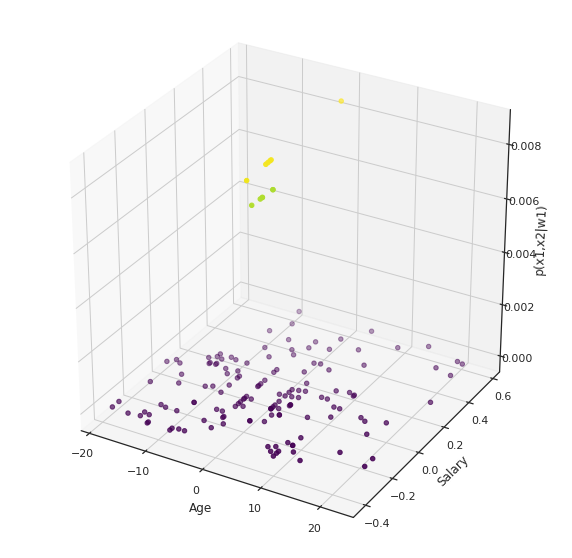

In [197]:
fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
ax.scatter3D(male_age_line,male_salary_line,male_norm_line,c=male_norm_line,cmap='viridis')
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
ax.set_zlabel('p(x1,x2|w1)')

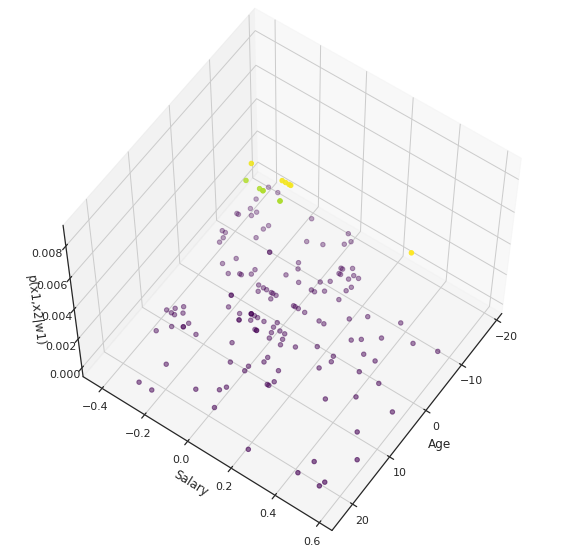

In [147]:
ax.view_init(60, 35)
fig

### Female Normale Distribution

In [234]:
female_mean_vector=np.array([age_female_mean,salary_female_mean])
female_result_list=list()
for i in range(len(normalize_female['Age'].values)):
    temp=np.array([normalize_female['Age'].values[i],normalize_female['EstimatedSalary'].values[i]])
    temp-=mean_vector
    female_result_list.append(temp)


In [186]:
k=multi_variant_normal_distribution(female_result_list,female_cov_determinant,female_sigma_inverse)
female_result_list=np.array(female_result_list)
k=np.array(k)

### Showing Female Normal Destribution 

In [188]:
female_age_line=female_result_list[:,0]
female_salary_line=female_result_list[:,1]
female_norm_line=k[:,0,0]

Text(0.5, 0, 'p(x1,x2|w2)')

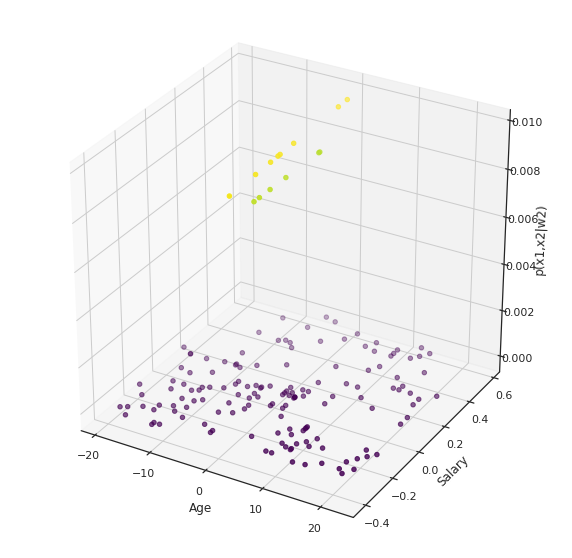

In [189]:
fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
ax.scatter3D(female_age_line,female_salary_line,female_norm_line,c=female_norm_line,cmap='viridis')
ax.set_xlabel('Age')
ax.set_ylabel('Salary')
ax.set_zlabel('p(x1,x2|w2)')

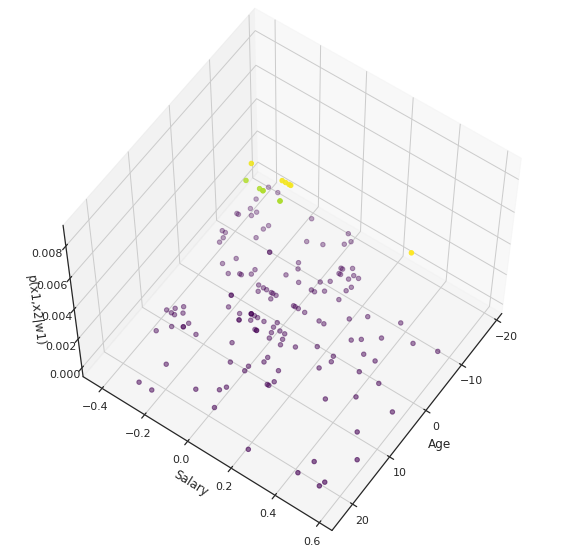

In [198]:
ax.view_init(60, 35)
fig

### Test and Validation

In [200]:
frame_test.head()

,Age,EstimatedSalary,Gender
132,30,87000,Male
309,38,50000,Female
341,35,75000,Male
196,30,79000,Female
246,35,50000,Female


In [207]:
min_age_test_value=frame_test['EstimatedSalary'].values.min()
max_age_test_value=frame_test['EstimatedSalary'].values.max()
test_values=list()
for i in frame_test['EstimatedSalary'].values:
    test_values.append(normalize(i,min_value=min_age_test_value,max_value=max_age_test_value))
arr_test_values=np.array(test_values)
arr_test_values=arr_test_values.reshape((80,1))
normalize_frame_test=frame_test.copy()
normalize_frame_test['EstimatedSalary']=arr_test_values

In [209]:
normalize_frame_test.head()

,Age,EstimatedSalary,Gender
132,30,0.533333,Male
309,38,0.259259,Female
341,35,0.444444,Male
196,30,0.474074,Female
246,35,0.259259,Female


In [265]:
def predict_label(male_prob,female_prob):
    if male_prob>female_prob:
        return 'Male'
    elif male_prob<female_prob:
        return 'Female'
    else:
        return random.choice(['Male','Female'])

In [254]:
false_detection=0
true_detection=0

In [272]:
for i in normalize_frame_test.values:
    male_x_test=np.array(i[0:2],dtype=np.float64)
    male_x_test-=mean_vector
    
    male_x_list=list()
    male_x_list.append(male_x_test)
    
    female_x_test=np.array(i[0:2],dtype=np.float64)
    female_x_test-=female_mean_vector
    female_x_list=list()
    female_x_list.append(female_x_test)
    
    male_test_norm_value=multi_variant_normal_distribution(male_x_list,male_cov_determinant,male_sigma_inverse)
    female_test_norm_value=multi_variant_normal_distribution(female_x_list,female_cov_determinant,female_sigma_inverse)
    
    predic=predict_label(male_test_norm_value,female_test_norm_value)
    
    if predic == i[2]:
        true_detection+=1
    else:
        false_detection+=1

In [273]:
print('The result of testing is :')
print('False Detection = {} of {}'.format(false_detection,len(normalize_frame_test)))
print('True Detection = {} of {}'.format(true_detection,len(normalize_frame_test)))

The result of testing is :
False Detection = 41 of 80
True Detection = 39 of 80
